In [4]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

nltk.download("stopwords")
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91999\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df = pd.read_csv("../dataset-tickets-multi-lang-4-20k.csv")

print(df.shape)
df.head()


(20000, 15)


,subject,body,answer,type,queue,priority,language,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
0,Unvorhergesehener Absturz der Datenanalyse-Pla...,Die Datenanalyse-Plattform brach unerwartet ab...,Ich werde Ihnen bei der Lösung des Problems he...,Incident,General Inquiry,low,de,Crash,Technical,Bug,Hardware,Resolution,Outage,Documentation,NaN
1,Customer Support Inquiry,Seeking information on digital strategies that...,We offer a variety of digital strategies and s...,Request,Customer Service,medium,en,Feedback,Sales,IT,Tech Support,NaN,NaN,NaN,NaN
2,Data Analytics for Investment,I am contacting you to request information on ...,I am here to assist you with data analytics to...,Request,Customer Service,medium,en,Technical,Product,Guidance,Documentation,Performance,Feature,NaN,NaN
3,Krankenhaus-Dienstleistung-Problem,Ein Medien-Daten-Sperrverhalten trat aufgrund ...,Zurück zur E-Mail-Beschwerde über den Sperrver...,Incident,Customer Service,high,de,Security,Breach,Login,Maintenance,Incident,Resolution,Feedback,NaN
4,Security,"Dear Customer Support, I am reaching out to in...","Dear [name], we take the security of medical d...",Request,Customer Service,medium,en,Security,Customer,Compliance,Breach,Documentation,Guidance,NaN,NaN


In [6]:
df["text"] = df["subject"].fillna("") + " " + df["body"].fillna("")

df = df[[
    "text",
    "type",       # issue classification
    "queue",      # routing
    "language",   # multilingual handling
    "answer"      # knowledge base
]].dropna()

df.head()


,text,type,queue,language,answer
0,Unvorhergesehener Absturz der Datenanalyse-Pla...,Incident,General Inquiry,de,Ich werde Ihnen bei der Lösung des Problems he...
1,Customer Support Inquiry Seeking information o...,Request,Customer Service,en,We offer a variety of digital strategies and s...
2,Data Analytics for Investment I am contacting ...,Request,Customer Service,en,I am here to assist you with data analytics to...
3,Krankenhaus-Dienstleistung-Problem Ein Medien-...,Incident,Customer Service,de,Zurück zur E-Mail-Beschwerde über den Sperrver...
4,"Security Dear Customer Support, I am reaching ...",Request,Customer Service,en,"Dear [name], we take the security of medical d..."


In [7]:
print("Ticket Types:\n")
print(df["type"].value_counts())

print("\nLanguages:\n")
print(df["language"].value_counts())


Ticket Types:

type
Incident    7978
Request     5763
Problem     4180
Change      2075
Name: count, dtype: int64

Languages:

language
en    11920
de     8076
Name: count, dtype: int64


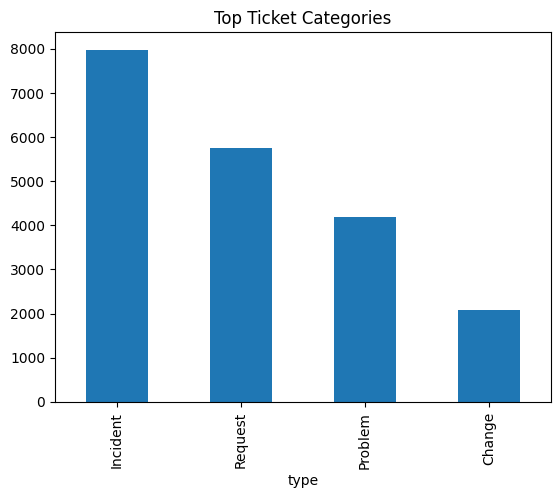

In [8]:
df["type"].value_counts().head(10).plot(kind="bar")
plt.title("Top Ticket Categories")
plt.show()


In [9]:
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = " ".join(w for w in text.split() if w not in stop_words)
    return text

df["clean_text"] = df["text"].apply(clean_text)

df[["text", "clean_text"]].head()


,text,clean_text
0,Unvorhergesehener Absturz der Datenanalyse-Pla...,unvorhergesehener absturz der datenanalyseplat...
1,Customer Support Inquiry Seeking information o...,customer support inquiry seeking information d...
2,Data Analytics for Investment I am contacting ...,data analytics investment contacting request i...
3,Krankenhaus-Dienstleistung-Problem Ein Medien-...,krankenhausdienstleistungproblem ein mediendat...
4,"Security Dear Customer Support, I am reaching ...",security dear customer support reaching inquir...


In [10]:
X = df["clean_text"]
y_type = df["type"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y_type, test_size=0.2, random_state=42, stratify=y_type
)


In [11]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [12]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)

y_pred_lr = lr.predict(X_test_tfidf)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.792
              precision    recall  f1-score   support

      Change       0.97      0.85      0.91       415
    Incident       0.71      0.87      0.78      1596
     Problem       0.59      0.34      0.43       836
     Request       0.95      0.99      0.97      1153

    accuracy                           0.79      4000
   macro avg       0.80      0.76      0.77      4000
weighted avg       0.78      0.79      0.78      4000



In [13]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

y_pred_nb = nb.predict(X_test_tfidf)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.76625


In [14]:
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)

y_pred_svm = svm.predict(X_test_tfidf)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))


SVM Accuracy: 0.796


In [15]:
y_lang = df["language"]

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(
    df["clean_text"], y_lang, test_size=0.2, random_state=42, stratify=y_lang
)

X_train_l_tfidf = tfidf.fit_transform(X_train_l)
X_test_l_tfidf = tfidf.transform(X_test_l)

lang_model = LogisticRegression(max_iter=1000)
lang_model.fit(X_train_l_tfidf, y_train_l)

print("Language Detection Accuracy:",
      accuracy_score(y_test_l, lang_model.predict(X_test_l_tfidf)))


Language Detection Accuracy: 0.9405


In [17]:
y_queue = df["queue"]

X_train_q, X_test_q, y_train_q, y_test_q = train_test_split(
    df["clean_text"], y_queue, test_size=0.2, random_state=42, stratify=y_queue
)

X_train_q_tfidf = tfidf.fit_transform(X_train_q)
X_test_q_tfidf = tfidf.transform(X_test_q)

queue_model = LogisticRegression(max_iter=1000)
queue_model.fit(X_train_q_tfidf, y_train_q)

print("Routing Accuracy:",
      accuracy_score(y_test_q, queue_model.predict(X_test_q_tfidf)))


Routing Accuracy: 0.41125


In [18]:
from sklearn.metrics.pairwise import cosine_similarity

kb_vectorizer = TfidfVectorizer(max_features=5000)
kb_vectors = kb_vectorizer.fit_transform(df["clean_text"])

def suggest_solution(text):
    vec = kb_vectorizer.transform([text])
    sim = cosine_similarity(vec, kb_vectors)
    idx = sim.argmax()
    return df.iloc[idx]["answer"]


In [19]:
def assign_priority(text, ticket_type):
    text = text.lower()

    if any(w in text for w in ["urgent", "asap", "immediately", "critical"]):
        return "High"
    if ticket_type.lower() in ["network", "vpn", "email"]:
        return "High"
    return "Medium"


In [20]:
def process_ticket(subject, body, user_id="EMP001"):
    raw_text = subject + " " + body
    clean = clean_text(raw_text)

    vec = tfidf.transform([clean])

    ticket_type = lr.predict(vec)[0]
    language = lang_model.predict(vec)[0]
    queue = queue_model.predict(vec)[0]
    priority = assign_priority(raw_text, ticket_type)
    solution = suggest_solution(clean)

    return {
        "Ticket Type": ticket_type,
        "Language": language,
        "Assigned Queue": queue,
        "Priority": priority,
        "Suggested Resolution": solution
    }


In [21]:
process_ticket(
    subject="Unable to connect to VPN",
    body="VPN is not connecting since morning, urgent access required"
)


{'Ticket Type': 'Incident',
 'Language': 'en',
 'Assigned Queue': 'IT Support',
 'Priority': 'High',
 'Suggested Resolution': "Dear [Your Name], thank you for contacting our support team, we are here to assist you in setting up a VPN on your Linux Mint router. To offer you a comprehensive guide, could you please tell us your router's model and the specific VPN service you plan to use? This information will help us provide you with precise instructions and advice for a stable and secure connection. If necessary, we can also arrange a call at [tel_num] to guide you through the process step-by-step."}

In [22]:
def send_email(email, message):
    return f"📧 Email sent to {email}"

def send_sms(phone, message):
    return f"📱 SMS sent to {phone}"


In [23]:
def chatbot_pipeline(name, emp_id, email, phone, subject, body):
    raw_text = subject + " " + body
    clean = clean_text(raw_text)
    vec = tfidf.transform([clean])

    ticket_type = lr.predict(vec)[0]
    language = lang_model.predict(vec)[0]
    queue = queue_model.predict(vec)[0]
    priority = assign_priority(raw_text, ticket_type)
    solution = suggest_solution(clean)

    email_status = send_email(email, "Your IT ticket has been registered successfully.")
    sms_status = send_sms(phone, "Your IT ticket has been registered.")

    result = f"""
🧑 Employee: {name} ({emp_id})

🎫 Ticket Details:
- Issue Type: {ticket_type}
- Language: {language}
- Assigned Team: {queue}
- Priority: {priority}

✅ Suggested Resolution:
{solution}

{email_status}
{sms_status}
"""
    return result


In [ ]:
import gradio as gr

interface = gr.Interface(
    fn=chatbot_pipeline,
    inputs=[
        gr.Textbox(label="Employee Name"),
        gr.Textbox(label="Employee ID"),
        gr.Textbox(label="Email Address"),
        gr.Textbox(label="Phone Number"),
        gr.Textbox(label="Issue Subject"),
        gr.Textbox(label="Issue Description", lines=4)
    ],
    outputs=gr.Textbox(label="Ticket Response"),
    title="🤖 POWERGRID AI IT Support Chatbot",
    description="Centralized AI-based ticketing system with NLP, routing, and self-service resolution."
)

interface.launch(share=True)


In [25]:
import joblib

joblib.dump(lr, "../backend/type_model.pkl")
joblib.dump(lang_model, "../backend/lang_model.pkl")
joblib.dump(queue_model, "../backend/queue_model.pkl")
joblib.dump(tfidf, "../backend/tfidf.pkl")
joblib.dump(df[["clean_text", "answer"]], "../backend/kb.pkl")


['../backend/kb.pkl']